In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib
import os
import warnings
warnings.filterwarnings('ignore')


In [79]:
#train = 'Dataset_Secciones_PRESIDENCIA.csv'
#test = 'Dataset_Secciones_PRESIDENCIA_TEST.csv'

train = 'Dataset_Secciones_SENADURIA_MR.csv'
test = 'Dataset_Secciones_SENADURIA_MR_TEST.csv'

#train = 'Dataset_Secciones_DIPUTACION_FEDERAL_MR.csv'
#test = 'Dataset_Secciones_DIPUTACION_FEDERAL_MR_TEST.csv'



## CARGA Y PREPARACIÓN DE DATOS


In [80]:
def cargar_datos_electorales(archivo= train):
    """Carga y prepara datos electorales"""
    df = pd.read_csv(archivo)
    #EXCLUYENDO METRICAS ELECTORALES: PARTICIPACION_PCT,COMPETITIVIDAD y FRAGMENTACION
    df = df.drop(columns=['PARTICIPACION_PCT', 'COMPETITIVIDAD', 'FRAGMENTACION'])

    #print(f"Dimensiones: {df.shape[0]} secciones × {df.shape[1]} variables")
    return df

def preparar_datos_simplificado(df):
    """Prepara datos con enfoque simplificado"""
        # 1. Identificar columnas electorales
    columnas_electorales = [col for col in df.columns if col.startswith('ELECTORAL_')]
    #print(f"Columnas electorales encontradas: {len(columnas_electorales)}")
    
    # 2. Identificar partidos principales (excluir metadatos)
    excluir = ['ANIO', 'CASILLAS', 'CARGO', 'GANADOR', 'NUM_VOTOS', 'TOTAL_VOTOS', 'LISTA_NOMINAL']
    partidos = [col for col in columnas_electorales 
                if not any(x in col.upper() for x in excluir)]
    
    

    
    """
    print(f"Partidos detectados: {len(partidos)}")
    for partido in partidos:
        print(f"   • {partido}")
    """
    # 3. Calcular total de votos válidos
    df['TOTAL_VOTOS_VALIDOS'] = df[partidos].sum(axis=1)
    
    # 4. Crear targets (porcentajes)
    targets = []
    for partido in partidos:
        nombre_target = partido.replace('ELECTORAL_', '') + '_PCT'
        df[nombre_target] = (df[partido] / df['TOTAL_VOTOS_VALIDOS'] * 100).fillna(0)
        targets.append(nombre_target)
    
    #print(f"Targets creados: {len(targets)}")
    
    # 5. Seleccionar variables demográficas clave
    variables_demograficas = [
        col for col in df.columns 
        if not col.startswith('ELECTORAL_') 
        and col not in ['SECCION', 'AGEB', 'TOTAL_VOTOS_VALIDOS'] + targets
        and df[col].dtype in ['float64', 'int64']
    ]
    
    #print(f"Variables demográficas disponibles: {len(variables_demograficas)}")
    
    return df, targets, variables_demograficas

# Cargar datos
df = cargar_datos_electorales()
#print(f"\nPrimeras columnas: {list(df.columns[:10])}")

# Preparar datos
df, targets, variables_demograficas = preparar_datos_simplificado(df)


## SELECCIÓN INTELIGENTE DE VARIABLES


In [81]:
def seleccionar_variables_clave(df, variables_demograficas, targets, n_variables=6):
    """Selecciona las variables más importantes usando múltiples criterios"""
    #print(f"SELECCIONANDO {n_variables} VARIABLES CLAVE...")
    
    # Preparar datos
    X = df[variables_demograficas].fillna(df[variables_demograficas].median())
    
    # Eliminar variables con poca varianza
    varianzas = X.var()
    variables_con_varianza = varianzas[varianzas > 0.01].index.tolist()
    X = X[variables_con_varianza]
    #print(f"Variables con varianza suficiente: {len(variables_con_varianza)}")
    
    # Normalizar para análisis (scaler temporal)
    scaler_temp = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler_temp.fit_transform(X), 
        columns=X.columns, 
        index=X.index
    )
    
    # Método 1: Correlación promedio con targets
    correlaciones = {}
    for var in X.columns:
        corrs = []
        for target in targets[:5]:  # Solo partidos principales
            if target in df.columns:
                corr = abs(df[var].corr(df[target]))
                if not np.isnan(corr):
                    corrs.append(corr)
        correlaciones[var] = np.mean(corrs) if corrs else 0
    
    # Método 2: Importancia Random Forest
    rf_scores = {}
    for target in targets[:3]:  # Solo top 3 partidos
        if target in df.columns:
            y = df[target].fillna(0)
            rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=3)
            rf.fit(X_scaled, y)
            for i, var in enumerate(X.columns):
                rf_scores[var] = rf_scores.get(var, 0) + rf.feature_importances_[i]
    
    # Combinar scores
    scores_finales = {}
    for var in X.columns:
        score_corr = correlaciones.get(var, 0)
        score_rf = rf_scores.get(var, 0)
        scores_finales[var] = (score_corr * 0.6) + (score_rf * 0.4)
    
    # Seleccionar top variables
    variables_seleccionadas = sorted(scores_finales.items(), key=lambda x: x[1], reverse=True)[:n_variables]
    
    """
    print(f"\nTOP {n_variables} VARIABLES SELECCIONADAS:")
    for i, (var, score) in enumerate(variables_seleccionadas, 1):
        print(f"   {i}. {var[:50]}... (Score: {score:.3f})")
    """

    variables_finales = [var for var, _ in variables_seleccionadas]
    
    # Crear scaler específico para las variables seleccionadas
    #print(f"\nCreando scaler para variables seleccionadas...")
    X_finales = df[variables_finales].fillna(df[variables_finales].median())
    scaler_final = StandardScaler()
    scaler_final.fit(X_finales)
    
    return variables_finales, scaler_final

# Seleccionar variables clave
variables_clave, scaler = seleccionar_variables_clave(df, variables_demograficas, targets, n_variables=6)


## MODELO SIMPLIFICADO CON REGULARIZACIÓN

In [82]:
## MODELO SIMPLIFICADO CON GRID SEARCH RÁPIDO
from sklearn.model_selection import GridSearchCV

def entrenar_modelo_con_grid_search(df, variables_clave, targets, scaler):
    """Entrena modelo con Grid Search rápido para optimizar hiperparámetros"""
    print("ENTRENANDO MODELO CON GRID SEARCH RÁPIDO...")
    print("=" * 60)
    
    # Preparar datos
    X = df[variables_clave].fillna(df[variables_clave].median())
    X_scaled = pd.DataFrame(
        scaler.transform(X), 
        columns=X.columns, 
        index=X.index
    )
    
    resultados = {}
    predicciones_totales = {}
    
    # Configurar validación cruzada
    cv_method = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Definir grids de hiperparámetros (versión rápida)
    grids = {
        'Ridge': {
            'modelo': Ridge(random_state=42),
            'param_grid': {
                'alpha': [0.1, 1.0, 5.0, 10.0]  # Solo 4 valores
            }
        },
        'Lasso': {
            'modelo': Lasso(random_state=42),
            'param_grid': {
                'alpha': [0.01, 0.1, 0.5, 1.0]  # Solo 4 valores
            }
        },
        'ElasticNet': {
            'modelo': ElasticNet(random_state=42),
            'param_grid': {
                'alpha': [0.1, 0.5, 1.0],  # Solo 3 valores
                'l1_ratio': [0.3, 0.5, 0.7]  # Solo 3 valores
            }
        }
    }
    
    # Entrenar para cada target
    for target in targets:
        if target not in df.columns:
            continue
            
        y = df[target].fillna(0)
        
        mejor_modelo = None
        mejor_cv = -np.inf
        mejor_nombre = None
        mejores_params = None
        
        print(f"\n🎯 Optimizando {target.replace('_PCT', '')}...")
        
        # Probar cada tipo de modelo con Grid Search
        for nombre_modelo, config in grids.items():
            print(f"  🔍 Probando {nombre_modelo}...")
            
            # Grid Search
            grid_search = GridSearchCV(
                estimator=config['modelo'],
                param_grid=config['param_grid'],
                cv=cv_method,
                scoring='r2',
                n_jobs=-1,  # Usar todos los cores
                verbose=0
            )
            
            # Entrenar Grid Search
            grid_search.fit(X_scaled, y)
            
            # Evaluar resultados
            cv_mean = grid_search.best_score_
            
            print(f"    ✅ Mejor CV: {cv_mean:.3f}")
            print(f"    📊 Mejores params: {grid_search.best_params_}")
            
            if cv_mean > mejor_cv:
                mejor_cv = cv_mean
                mejor_modelo = grid_search.best_estimator_
                mejor_nombre = nombre_modelo
                mejores_params = grid_search.best_params_
        
        # Entrenar mejor modelo con todos los datos
        mejor_modelo.fit(X_scaled, y)
        y_pred = mejor_modelo.predict(X_scaled)
        
        # Calcular métricas finales
        r2 = r2_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        
        # Validación cruzada final con el mejor modelo
        cv_scores_final = cross_val_score(mejor_modelo, X_scaled, y, cv=cv_method, scoring='r2')
        cv_mean_final = cv_scores_final.mean()
        cv_std = cv_scores_final.std()
        
        # Guardar resultados
        resultados[target] = {
            'modelo': mejor_modelo,
            'tipo_modelo': mejor_nombre,
            'mejores_params': mejores_params,
            'r2': r2,
            'mae': mae,
            'cv_mean': cv_mean_final,
            'cv_std': cv_std,
            'predicciones': y_pred
        }
        
        predicciones_totales[target] = y_pred.mean()
        
        # Mostrar resultados
        partido = target.replace('_PCT', '').ljust(12)
        print(f"�� {partido} | {mejor_nombre} | R²: {r2:6.3f} | CV: {cv_mean_final:6.3f}±{cv_std:.3f} | MAE: {mae:5.2f}")
        print(f"   📊 Parámetros: {mejores_params}")
    
    return resultados, predicciones_totales

# Entrenar modelo con Grid Search
resultados, predicciones_totales = entrenar_modelo_con_grid_search(df, variables_clave, targets, scaler)

ENTRENANDO MODELO CON GRID SEARCH RÁPIDO...

🎯 Optimizando PAN...
  🔍 Probando Ridge...
    ✅ Mejor CV: -0.473
    📊 Mejores params: {'alpha': 10.0}
  🔍 Probando Lasso...
    ✅ Mejor CV: -0.345
    📊 Mejores params: {'alpha': 1.0}
  🔍 Probando ElasticNet...
    ✅ Mejor CV: -0.304
    📊 Mejores params: {'alpha': 1.0, 'l1_ratio': 0.5}
�� PAN          | ElasticNet | R²:  0.293 | CV: -0.304±0.833 | MAE:  3.28
   📊 Parámetros: {'alpha': 1.0, 'l1_ratio': 0.5}

🎯 Optimizando PRI...
  🔍 Probando Ridge...
    ✅ Mejor CV: -0.210
    📊 Mejores params: {'alpha': 10.0}
  🔍 Probando Lasso...
    ✅ Mejor CV: -0.146
    📊 Mejores params: {'alpha': 1.0}
  🔍 Probando ElasticNet...
    ✅ Mejor CV: -0.098
    📊 Mejores params: {'alpha': 1.0, 'l1_ratio': 0.3}
�� PRI          | ElasticNet | R²:  0.151 | CV: -0.098±0.261 | MAE:  1.88
   📊 Parámetros: {'alpha': 1.0, 'l1_ratio': 0.3}

🎯 Optimizando PRD...
  🔍 Probando Ridge...
    ✅ Mejor CV: -0.048
    📊 Mejores params: {'alpha': 10.0}
  🔍 Probando Lasso...
 

## ANÁLISIS DE RESULTADOS


In [83]:
## ANÁLISIS DE RESULTADOS CON GRID SEARCH
def analizar_resultados(resultados, predicciones_totales):
    """Analiza resultados incluyendo información de Grid Search"""
    print("\n" + "=" * 80)
    print("ANÁLISIS DETALLADO CON GRID SEARCH")
    print("=" * 80)
    
    # Métricas generales
    r2_scores = [res['r2'] for res in resultados.values()]
    cv_scores = [res['cv_mean'] for res in resultados.values()]
    mae_scores = [res['mae'] for res in resultados.values()]
    
    print(f"\n�� MÉTRICAS GENERALES:")
    print(f"   R² promedio: {np.mean(r2_scores):.3f}")
    print(f"   CV promedio: {np.mean(cv_scores):.3f}")
    print(f"   MAE promedio: {np.mean(mae_scores):.2f}%")
    
    # Análisis por tipo de modelo
    tipos_modelo = [res['tipo_modelo'] for res in resultados.values()]
    conteo_tipos = {}
    for tipo in tipos_modelo:
        conteo_tipos[tipo] = conteo_tipos.get(tipo, 0) + 1
    
    print(f"\n🤖 DISTRIBUCIÓN DE MODELOS SELECCIONADOS:")
    for tipo, count in conteo_tipos.items():
        print(f"   {tipo}: {count}/{len(resultados)} partidos")
    
    # Mejores parámetros por modelo
    print(f"\n⚙️ MEJORES PARÁMETROS POR PARTIDO:")
    for target, res in resultados.items():
        partido = target.replace('_PCT', '').ljust(12)
        tipo = res['tipo_modelo'].ljust(10)
        params = res['mejores_params']
        print(f"   {partido} | {tipo} | {params}")
    
    # Tendencia al voto
    print(f"\n🏆 TENDENCIA AL VOTO (MODELO CON GRID SEARCH):")
    print("-" * 40)
    
    # Ordenar por predicción
    tendencia_ordenada = sorted(predicciones_totales.items(), key=lambda x: x[1], reverse=True)
    
    total_prediccion = sum(predicciones_totales.values())
    
    for i, (partido, porcentaje) in enumerate(tendencia_ordenada, 1):
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "📊"
        nombre = partido.replace('_PCT', '').ljust(10)
        print(f"{emoji} {i:2d}° {nombre}: {porcentaje:5.1f}%")
        
    # Diagnóstico de sobreajuste
    print(f"\n🔍 DIAGNÓSTICO DE SOBREAJUSTE:")
    print("-" * 40)
    
    for target, res in resultados.items():
        partido = target.replace('_PCT', '').ljust(12)
        r2 = res['r2']
        cv = res['cv_mean']
        diferencia = r2 - cv
        
        if diferencia < 0.1:
            estado = "✅ Bueno"
        elif diferencia < 0.3:
            estado = "⚠️ Moderado"
        else:
            estado = "❌ Sobreajuste"
        
        print(f"{partido} | Diff: {diferencia:5.3f} | {estado}")

# Analizar resultados con Grid Search
analizar_resultados(resultados, predicciones_totales)


ANÁLISIS DETALLADO CON GRID SEARCH

�� MÉTRICAS GENERALES:
   R² promedio: 0.263
   CV promedio: 0.091
   MAE promedio: 1.04%

🤖 DISTRIBUCIÓN DE MODELOS SELECCIONADOS:
   ElasticNet: 6/13 partidos
   Lasso: 3/13 partidos
   Ridge: 4/13 partidos

⚙️ MEJORES PARÁMETROS POR PARTIDO:
   PAN          | ElasticNet | {'alpha': 1.0, 'l1_ratio': 0.5}
   PRI          | ElasticNet | {'alpha': 1.0, 'l1_ratio': 0.3}
   PRD          | ElasticNet | {'alpha': 0.1, 'l1_ratio': 0.3}
   PT           | Lasso      | {'alpha': 0.1}
   PVEM         | Ridge      | {'alpha': 10.0}
   MC           | ElasticNet | {'alpha': 0.5, 'l1_ratio': 0.3}
   MORENA       | Ridge      | {'alpha': 5.0}
   PAN_PRD      | Lasso      | {'alpha': 0.1}
   PT_MORENA    | ElasticNet | {'alpha': 0.1, 'l1_ratio': 0.3}
   PCPP         | Ridge      | {'alpha': 0.1}
   PSI          | Ridge      | {'alpha': 0.1}
   NA           | Lasso      | {'alpha': 0.5}
   ES           | ElasticNet | {'alpha': 0.1, 'l1_ratio': 0.7}

🏆 TENDENCIA AL V

## EXPORTAR MODELO ENTRENADO


In [84]:
def exportar_modelo_entrenado(resultados, scaler, variables_clave, targets):
    """Exporta el modelo entrenado con todos sus componentes"""    
    # Crear directorio
    directorio = 'MODELO_ENTRENADO'
    os.makedirs(directorio, exist_ok=True)
    
    # Crear paquete del modelo
    modelo_completo = {
        'scaler': scaler,
        'variables_clave': variables_clave,
        'targets': targets,
        'modelos': {target: res['modelo'] for target, res in resultados.items()},
        'resultados_entrenamiento': {
            target: {k: v for k, v in res.items() if k != 'predicciones'}
            for target, res in resultados.items()
        },
        'metadatos': {
            'fecha_entrenamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'n_variables': len(variables_clave),
            'n_partidos': len(targets)
        }
    }
    
    # Guardar modelo
    ruta_modelo = os.path.join(directorio, 'modelo_electoral_Tendencia_Al_Voto.pkl')
    joblib.dump(modelo_completo, ruta_modelo)
    
    # Crear resumen
    ruta_resumen = os.path.join(directorio, 'resumen_modelo.txt')
    with open(ruta_resumen, 'w', encoding='utf-8') as f:
        f.write(" MODELO ELECTORAL SIMPLIFICADO\\n")
        f.write("=" * 50 + "\\n\\n")
        f.write(f" Entrenado: {modelo_completo['metadatos']['fecha_entrenamiento']}\\n")
        f.write(f" Variables: {len(variables_clave)}\\n")
        f.write(f"  Partidos: {len(targets)}\\n\\n")
        
        f.write(" VARIABLES UTILIZADAS:\\n")
        for i, var in enumerate(variables_clave, 1):
            f.write(f"  {i}. {var}\\n")
        
        f.write("\\n RESULTADOS POR PARTIDO:\\n")
        for target, res in resultados.items():
            partido = target.replace('_PCT', '')
            f.write(f"  • {partido}: R²={res['r2']:.3f}, CV={res['cv_mean']:.3f}\\n")
    
    print(f" Modelo exportado a: {directorio}/")
    print(f" Archivo: modelo_electoral.pkl")
    print(f" Resumen: resumen_modelo.txt")
    
    return directorio

# Exportar modelo
directorio_modelo = exportar_modelo_entrenado(resultados, scaler, variables_clave, targets)


 Modelo exportado a: MODELO_ENTRENADO/
 Archivo: modelo_electoral.pkl
 Resumen: resumen_modelo.txt


---
## PROBAR MODELO CON NUEVO DATASET


In [85]:
# CARGAR MODELO GUARDADO
def cargar_modelo_entrenado(directorio='MODELO_ENTRENADO'):
    """Carga el modelo previamente entrenado"""
    #print(f"CARGANDO MODELO DESDE: {directorio}/")
    
    ruta_modelo = os.path.join(directorio, 'modelo_electoral_Tendencia_Al_Voto.pkl')
    if not os.path.exists(ruta_modelo):
        raise FileNotFoundError(f"❌ Modelo no encontrado: {ruta_modelo}")
    
    modelo_cargado = joblib.load(ruta_modelo)
    
    """
    print(" MODELO CARGADO EXITOSAMENTE")
    print(f" Entrenado: {modelo_cargado['metadatos']['fecha_entrenamiento']}")
    print(f" Variables: {modelo_cargado['metadatos']['n_variables']}")
    print(f"  Partidos: {modelo_cargado['metadatos']['n_partidos']}")
    """

    return modelo_cargado

# Cargar modelo (comentar si ya está en memoria)
# modelo_cargado = cargar_modelo_entrenado()

# Si ya tienes el modelo en memoria, usar estas variables:
modelo_cargado = {
    'scaler': scaler,
    'variables_clave': variables_clave, 
    'targets': targets,
    'modelos': {target: res['modelo'] for target, res in resultados.items()},
    'metadatos': {'fecha_entrenamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
}

print("Usando modelo de la sesión actual")


Usando modelo de la sesión actual


In [86]:
#ESPECIFICAR NUEVO DATASET
#CAMBIAR ESTE ARCHIVO POR EL DATASET QUE QUIERES PROBAR
NUEVO_DATASET = test

print(f"Dataset seleccionado: {NUEVO_DATASET}")
print("Para cambiar, modifica la variable NUEVO_DATASET arriba")

# Verificar que el archivo existe
if os.path.exists(NUEVO_DATASET):
    print(f"Archivo encontrado")
else:
    print(f"Archivo no encontrado")
    print("Archivos disponibles:")
    archivos = [f for f in os.listdir('.') if f.endswith('.csv')]
    for archivo in archivos:
        print(f"   • {archivo}")


Dataset seleccionado: Dataset_Secciones_SENADURIA_MR_TEST.csv
Para cambiar, modifica la variable NUEVO_DATASET arriba
Archivo encontrado


In [87]:
# APLICAR MODELO AL NUEVO DATASET
def aplicar_modelo_a_dataset(modelo_cargado, archivo_nuevo):
    """Aplica el modelo cargado a un nuevo dataset"""
    print(f"APLICANDO MODELO A: {archivo_nuevo}")
    print("=" * 60)
    
    # Cargar nuevo dataset
    df_nuevo = pd.read_csv(archivo_nuevo)
    df_nuevo = df_nuevo.drop(columns=['PARTICIPACION_PCT', 'COMPETITIVIDAD', 'FRAGMENTACION'])
    #print(f"Dataset cargado: {df_nuevo.shape[0]} filas × {df_nuevo.shape[1]} columnas")
    
    # Preparar datos del nuevo dataset
    df_nuevo, targets_nuevo, _ = preparar_datos_simplificado(df_nuevo)
    
    # Verificar variables necesarias
    variables_modelo = modelo_cargado['variables_clave']
    variables_faltantes = [var for var in variables_modelo if var not in df_nuevo.columns]
    
    if variables_faltantes:
        print(f"Variables faltantes:")
        for var in variables_faltantes:
            print(f"   • {var}")
        return None, None, None
    
    print(f"Todas las variables están presentes")
    
    # Preparar datos para predicción
    X_nuevo = df_nuevo[variables_modelo].fillna(df_nuevo[variables_modelo].median())
    X_nuevo_scaled = pd.DataFrame(
        modelo_cargado['scaler'].transform(X_nuevo),
        columns=variables_modelo,
        index=X_nuevo.index
    )
    
    # Hacer predicciones
    predicciones = {}
    valores_reales = {}
    
    print(f"\\nPREDICCIONES vs VALORES REALES:")
    print(f"{'Partido':<12} {'Pred_Media':<10} {'Real_Media':<10} {'MAE':<8} {'R²':<8}")
    print("-" * 55)
    
    for target in modelo_cargado['targets']:
        if target in modelo_cargado['modelos']:
            # Predicción
            modelo_partido = modelo_cargado['modelos'][target]
            y_pred = modelo_partido.predict(X_nuevo_scaled)
            predicciones[target] = y_pred
            
            # Valores reales (si existen)
            if target in df_nuevo.columns:
                y_real = df_nuevo[target].values
                valores_reales[target] = y_real
                
                # Métricas
                mae = mean_absolute_error(y_real, y_pred)
                r2 = r2_score(y_real, y_pred)
                
                partido = target.replace('_PCT', '')[:11]
                print(f"{partido:<12} {y_pred.mean():<10.1f} {y_real.mean():<10.1f} {mae:<8.2f} {r2:<8.3f}")
            else:
                partido = target.replace('_PCT', '')[:11]
                print(f"{partido:<12} {y_pred.mean():<10.1f} {'N/A':<10} {'N/A':<8} {'N/A':<8}")
    
    # Crear dataset de resultados
    df_resultados = df_nuevo[['SECCION', 'AGEB']].copy() if 'SECCION' in df_nuevo.columns else df_nuevo.copy()
    
    for target, pred in predicciones.items():
        df_resultados[f'{target}_PRED'] = pred
        if target in valores_reales:
            df_resultados[f'{target}_REAL'] = valores_reales[target]
            df_resultados[f'{target}_ERROR'] = abs(valores_reales[target] - pred)
    
    return df_resultados, predicciones, valores_reales

# Aplicar modelo si el archivo existe
if os.path.exists(NUEVO_DATASET):
    df_resultados, predicciones_nuevo, valores_reales_nuevo = aplicar_modelo_a_dataset(modelo_cargado, NUEVO_DATASET)
else:
    print("No se puede aplicar el modelo sin un dataset válido")


APLICANDO MODELO A: Dataset_Secciones_SENADURIA_MR_TEST.csv
Todas las variables están presentes
\nPREDICCIONES vs VALORES REALES:
Partido      Pred_Media Real_Media MAE      R²      
-------------------------------------------------------
PAN          19.0       17.0       3.08     -0.270  
PRI          11.0       11.7       3.07     0.132   
PRD          1.4        1.4        0.31     0.145   
PT           4.0        3.3        1.02     0.333   
PVEM         4.8        4.6        0.89     0.092   
MC           2.5        2.4        0.54     0.292   
MORENA       51.5       54.4       3.23     -1.204  
PAN_PRD      0.1        0.1        0.10     -0.005  
PT_MORENA    0.7        0.6        0.19     0.399   
PCPP         0.0        0.0        0.00     1.000   
PSI          0.0        0.0        0.00     1.000   
NA           2.3        2.0        0.58     -0.120  
ES           2.3        2.4        0.79     -0.067  


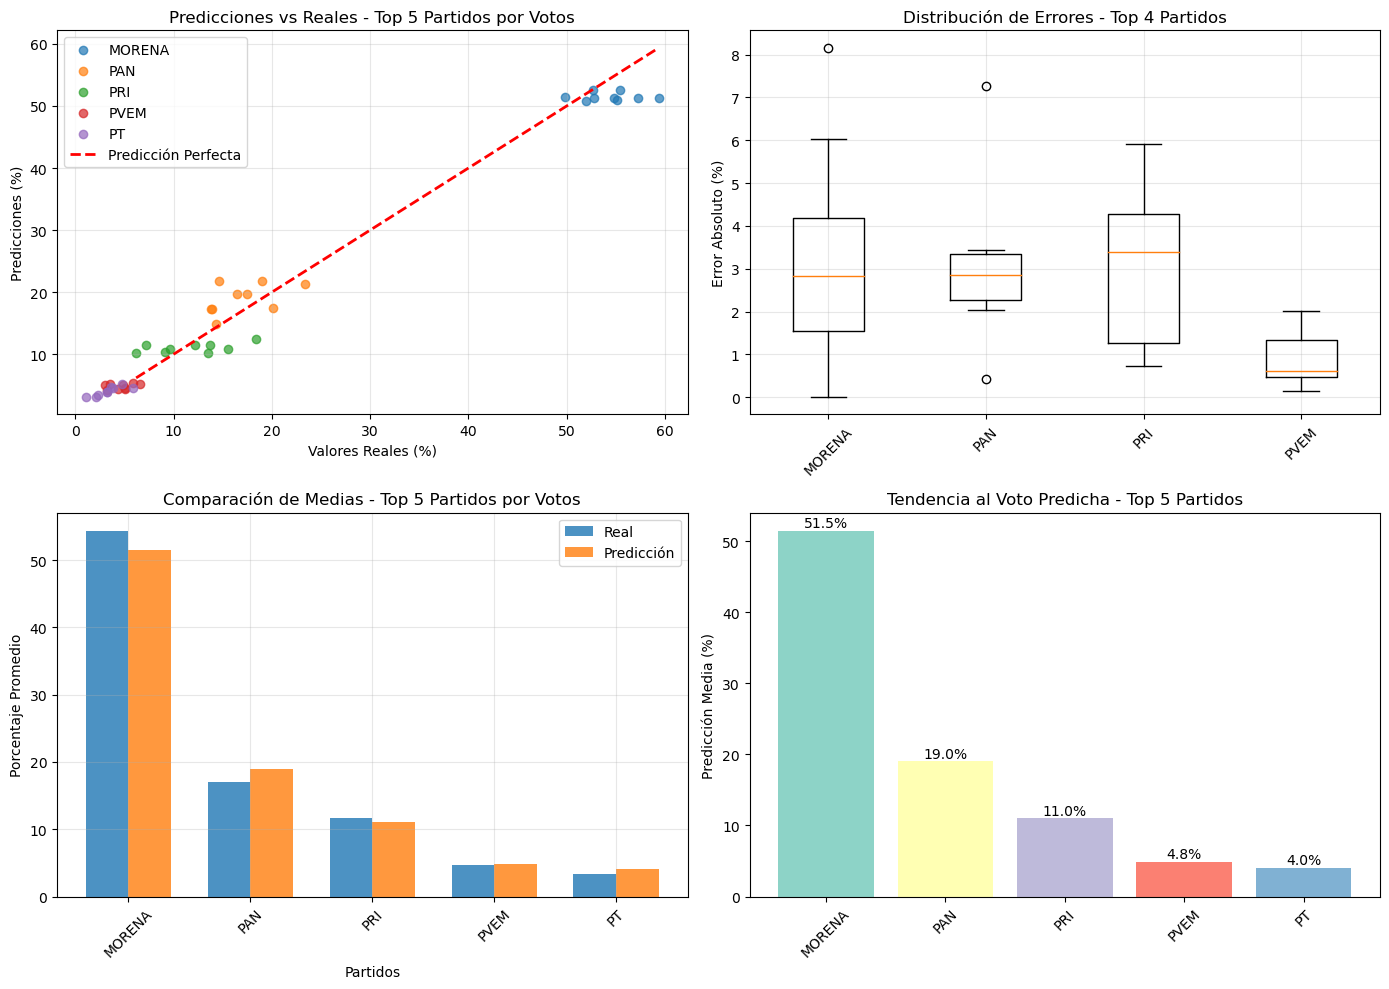


RESUMEN ESTADÍSTICO:
 MAE promedio (Top 5): 2.26%
 R² promedio (Top 5): -0.184

TENDENCIA AL VOTO EN Dataset_Secciones_SENADURIA_MR_TEST.csv:
----------------------------------------
🥇  1° MORENA    :  51.5%
🥈  2° PAN       :  19.0%
🥉  3° PRI       :  11.0%
📊  4° PVEM      :   4.8%
📊  5° PT        :   4.0%
📊  6° MC        :   2.5%
📊  7° NA        :   2.3%
📊  8° ES        :   2.3%
📊  9° PRD       :   1.4%
📊 10° PT_MORENA :   0.7%
📊 11° PAN_PRD   :   0.1%
📊 12° PCPP      :   0.0%
📊 13° PSI       :   0.0%


In [88]:
#VISUALIZAR RESULTADOS DEL NUEVO DATASET
def visualizar_comparacion(predicciones_nuevo, valores_reales_nuevo):
    """Visualiza comparación entre predicciones y valores reales"""
    
    if not predicciones_nuevo:
        print("No hay predicciones para visualizar")
        return
        
    # Determinar partidos con valores reales
    partidos_con_reales = [target for target in valores_reales_nuevo.keys()]
    
    if partidos_con_reales:
        # Ordenar partidos por porcentaje promedio de votos (de mayor a menor)
        partidos_ordenados = []
        for target in partidos_con_reales:
            porcentaje_promedio = np.mean(valores_reales_nuevo[target])
            partidos_ordenados.append((target, porcentaje_promedio))
        
        # Ordenar de mayor a menor porcentaje
        partidos_ordenados.sort(key=lambda x: x[1], reverse=True)
        
        # Tomar los top 5 partidos con más votos
        top_partidos = [partido for partido, _ in partidos_ordenados[:5]]
        
        # Crear gráficas de comparación
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Scatter plot predicciones vs reales
        ax1 = axes[0, 0]
        for target in top_partidos:  # Top 5 partidos por votos
            y_real = valores_reales_nuevo[target]
            y_pred = predicciones_nuevo[target]
            ax1.scatter(y_real, y_pred, label=target.replace('_PCT', ''), alpha=0.7)
        
        # Línea perfecta
        all_reales = np.concatenate([valores_reales_nuevo[t] for t in top_partidos[:3]])
        all_preds = np.concatenate([predicciones_nuevo[t] for t in top_partidos[:3]])
        min_val, max_val = min(all_reales.min(), all_preds.min()), max(all_reales.max(), all_preds.max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')
        
        ax1.set_xlabel('Valores Reales (%)')
        ax1.set_ylabel('Predicciones (%)')
        ax1.set_title('Predicciones vs Reales - Top 5 Partidos por Votos')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Errores por partido
        ax2 = axes[0, 1]
        errores_data = []
        partidos_labels = []
        
        for target in top_partidos[:4]:  # Top 4 para claridad
            errores = abs(valores_reales_nuevo[target] - predicciones_nuevo[target])
            errores_data.append(errores)
            partidos_labels.append(target.replace('_PCT', ''))
        
        ax2.boxplot(errores_data, labels=partidos_labels)
        ax2.set_ylabel('Error Absoluto (%)')
        ax2.set_title('Distribución de Errores - Top 4 Partidos')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # 3. Comparación de medias
        ax3 = axes[1, 0]
        partidos_nombres = [t.replace('_PCT', '') for t in top_partidos]  # Usar top_partidos
        medias_reales = [np.mean(valores_reales_nuevo[t]) for t in top_partidos]  # Usar top_partidos
        medias_pred = [np.mean(predicciones_nuevo[t]) for t in top_partidos]  # Usar top_partidos
        
        x = np.arange(len(partidos_nombres))
        width = 0.35
        
        ax3.bar(x - width/2, medias_reales, width, label='Real', alpha=0.8)
        ax3.bar(x + width/2, medias_pred, width, label='Predicción', alpha=0.8)
        ax3.set_xlabel('Partidos')
        ax3.set_ylabel('Porcentaje Promedio')
        ax3.set_title('Comparación de Medias - Top 5 Partidos por Votos')
        ax3.set_xticks(x)
        ax3.set_xticklabels(partidos_nombres, rotation=45)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Tendencia predicha
        ax4 = axes[1, 1]
        # Usar solo los top partidos para la tendencia predicha
        tendencia_top = [(t.replace('_PCT', ''), np.mean(predicciones_nuevo[t])) for t in top_partidos]
        tendencia_top.sort(key=lambda x: x[1], reverse=True)
        
        partidos_tend = [p[0] for p in tendencia_top]
        valores_tend = [p[1] for p in tendencia_top]
        
        bars = ax4.bar(partidos_tend, valores_tend, color=plt.cm.Set3(np.arange(len(partidos_tend))))
        ax4.set_ylabel('Predicción Media (%)')
        ax4.set_title('Tendencia al Voto Predicha - Top 5 Partidos')
        ax4.tick_params(axis='x', rotation=45)
        
        # Agregar valores en barras
        for bar, valor in zip(bars, valores_tend):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{valor:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Resumen estadístico
        print(f"\nRESUMEN ESTADÍSTICO:")
        print("=" * 50)
        
        # Calcular métricas solo para top partidos
        mae_promedio = np.mean([mean_absolute_error(valores_reales_nuevo[t], predicciones_nuevo[t]) 
                               for t in top_partidos])
        r2_promedio = np.mean([r2_score(valores_reales_nuevo[t], predicciones_nuevo[t]) 
                              for t in top_partidos])
        
        print(f" MAE promedio (Top 5): {mae_promedio:.2f}%")
        print(f" R² promedio (Top 5): {r2_promedio:.3f}")
        
    else:
        print("No hay valores reales para comparar, mostrando solo predicciones")
        
        # Solo mostrar tendencia predicha
        plt.figure(figsize=(10, 6))
        
        todas_predicciones = [(t.replace('_PCT', ''), np.mean(p)) for t, p in predicciones_nuevo.items()]
        todas_predicciones.sort(key=lambda x: x[1], reverse=True)
        
        partidos = [p[0] for p in todas_predicciones]
        valores = [p[1] for p in todas_predicciones]
        
        bars = plt.bar(partidos, valores, color=plt.cm.Set3(np.arange(len(partidos))))
        plt.ylabel('Predicción Media (%)')
        plt.title('Tendencia al Voto Predicha')
        plt.xticks(rotation=45)
        
        for bar, valor in zip(bars, valores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{valor:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

# Visualizar si hay resultados
if 'predicciones_nuevo' in locals() and predicciones_nuevo:
    visualizar_comparacion(predicciones_nuevo, valores_reales_nuevo)
    
    # Mostrar tendencia final
    print(f"\nTENDENCIA AL VOTO EN {NUEVO_DATASET}:")
    print("-" * 40)
    
    tendencia = [(t.replace('_PCT', ''), np.mean(p)) for t, p in predicciones_nuevo.items()]
    tendencia.sort(key=lambda x: x[1], reverse=True)
    
    for i, (partido, porcentaje) in enumerate(tendencia, 1):
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "📊"
        print(f"{emoji} {i:2d}° {partido:<10}: {porcentaje:5.1f}%")
else:
    print("No hay resultados para visualizar")

In [89]:
# ================================================================================
# TABLA DETALLADA: PREDICCIÓN vs REAL POR AGEB/SECCIÓN
# ================================================================================

def mostrar_tabla_detallada_predicciones(predicciones_nuevo, valores_reales_nuevo, df_nuevo):
    """
    Muestra tabla detallada con predicciones vs valores reales por AGEB/sección
    """
    print("📊 TABLA DETALLADA: PREDICCIÓN vs REAL POR AGEB/SECCIÓN")
    print("=" * 80)
    
    # Obtener partidos con valores reales
    partidos_con_reales = [target for target in valores_reales_nuevo.keys()]
    
    if not partidos_con_reales:
        print("❌ No hay valores reales para comparar")
        return
    
    # Ordenar partidos por porcentaje promedio de votos (de mayor a menor)
    partidos_ordenados = []
    for target in partidos_con_reales:
        porcentaje_promedio = np.mean(valores_reales_nuevo[target])
        partidos_ordenados.append((target, porcentaje_promedio))
    
    partidos_ordenados.sort(key=lambda x: x[1], reverse=True)
    top_partidos = [partido for partido, _ in partidos_ordenados[:5]]  # Top 5 partidos
    
    # Crear DataFrame con resultados detallados
    resultados_detallados = []
    
    for i in range(len(next(iter(predicciones_nuevo.values())))):
        fila = {}
        
        # Agregar información de la sección/AGEB
        if 'SECCION' in df_nuevo.columns:
            fila['SECCION'] = df_nuevo.iloc[i]['SECCION']
        elif 'AGEB' in df_nuevo.columns:
            fila['AGEB'] = df_nuevo.iloc[i]['AGEB']
        else:
            fila['ID'] = i + 1
        
        # Agregar datos para cada partido
        for target in top_partidos:
            partido_nombre = target.replace('_PCT', '')
            
            # Valores reales y predichos
            real = valores_reales_nuevo[target][i]
            pred = predicciones_nuevo[target][i]
            diferencia = abs(real - pred)
            
            fila[f'{partido_nombre}_REAL'] = real
            fila[f'{partido_nombre}_PRED'] = pred
            fila[f'{partido_nombre}_DIF'] = diferencia
        
        resultados_detallados.append(fila)
    
    # Crear DataFrame
    df_resultados = pd.DataFrame(resultados_detallados)
    
    # Mostrar tabla formateada
    print(f"\n📋 RESULTADOS DETALLADOS (Top 5 Partidos):")
    print("-" * 120)
    
    # Crear encabezados
    headers = ['ID']
    for partido in top_partidos:
        partido_nombre = partido.replace('_PCT', '')
        headers.extend([f'{partido_nombre}_REAL', f'{partido_nombre}_PRED', f'{partido_nombre}_DIF'])
    
    # Imprimir encabezados
    header_line = f"{'ID':<8}"
    for partido in top_partidos:
        partido_nombre = partido.replace('_PCT', '')
        header_line += f"{partido_nombre}_REAL {partido_nombre}_PRED {partido_nombre}_DIF "
    print(header_line)
    print("-" * 120)
    
    # Imprimir datos
    for idx, row in df_resultados.iterrows():
        # ID de la sección
        if 'SECCION' in row:
            id_str = f"{row['SECCION']:<8}"
        elif 'AGEB' in row:
            id_str = f"{row['AGEB']:<8}"
        else:
            id_str = f"{row['ID']:<8}"
        
        # Datos de cada partido
        data_line = id_str
        for partido in top_partidos:
            partido_nombre = partido.replace('_PCT', '')
            real = row[f'{partido_nombre}_REAL']
            pred = row[f'{partido_nombre}_PRED']
            dif = row[f'{partido_nombre}_DIF']
            
            data_line += f"{real:8.1f} {pred:8.1f} {dif:8.1f} "
        
        print(data_line)
    
    print("-" * 120)
    
    # Mostrar resumen estadístico por partido
    print(f"\n📈 RESUMEN ESTADÍSTICO POR PARTIDO:")
    print("-" * 60)
    print(f"{'Partido':<12} {'MAE':<8} {'Max_Error':<10} {'Min_Error':<10}")
    print("-" * 60)
    
    for partido in top_partidos:
        partido_nombre = partido.replace('_PCT', '')
        diferencias = df_resultados[f'{partido_nombre}_DIF']
        
        mae = np.mean(diferencias)
        max_error = np.max(diferencias)
        min_error = np.min(diferencias)
        
        print(f"{partido_nombre:<12} {mae:<8.2f} {max_error:<10.2f} {min_error:<10.2f}")
    
    print("-" * 60)
    
    # Mostrar casos con mayor error
    print(f"\n⚠️ CASOS CON MAYOR ERROR:")
    print("-" * 60)
    
    # Encontrar el caso con mayor error total
    errores_totales = []
    for idx, row in df_resultados.iterrows():
        error_total = sum([row[f'{partido.replace("_PCT", "")}_DIF'] for partido in top_partidos])
        errores_totales.append((idx, error_total))
    
    # Ordenar por error total (de mayor a menor)
    errores_totales.sort(key=lambda x: x[1], reverse=True)
    
    # Mostrar top 5 casos con mayor error
    for i, (idx, error_total) in enumerate(errores_totales[:5]):
        row = df_resultados.iloc[idx]
        
        if 'SECCION' in row:
            id_str = f"SECCIÓN {row['SECCION']}"
        elif 'AGEB' in row:
            id_str = f"AGEB {row['AGEB']}"
        else:
            id_str = f"ID {row['ID']}"
        
        print(f"{i+1}. {id_str}: Error total = {error_total:.2f}%")
        
        # Mostrar errores por partido para este caso
        for partido in top_partidos:
            partido_nombre = partido.replace('_PCT', '')
            real = row[f'{partido_nombre}_REAL']
            pred = row[f'{partido_nombre}_PRED']
            dif = row[f'{partido_nombre}_DIF']
            
            print(f"   • {partido_nombre}: {real:.1f}% → {pred:.1f}% (Error: {dif:.1f}%)")
    
    return df_resultados

def exportar_tabla_detallada(df_resultados, nombre_archivo='resultados_detallados_predicciones.csv'):
    """
    Exporta la tabla detallada a CSV
    """
    try:
        df_resultados.to_csv(nombre_archivo, index=False, encoding='utf-8')
        print(f"\n✅ Tabla detallada exportada a: {nombre_archivo}")
        print(f"📊 Filas exportadas: {len(df_resultados)}")
        print(f"📊 Columnas exportadas: {len(df_resultados.columns)}")
    except Exception as e:
        print(f"❌ Error al exportar: {str(e)}")

# Función para mostrar tabla simplificada (solo diferencias)
def mostrar_tabla_diferencias(predicciones_nuevo, valores_reales_nuevo, df_nuevo):
    """
    Muestra tabla simplificada solo con diferencias
    """
    print("�� TABLA DE DIFERENCIAS: PREDICCIÓN vs REAL")
    print("=" * 60)
    
    partidos_con_reales = [target for target in valores_reales_nuevo.keys()]
    
    if not partidos_con_reales:
        print("❌ No hay valores reales para comparar")
        return
    
    # Ordenar partidos por importancia
    partidos_ordenados = []
    for target in partidos_con_reales:
        porcentaje_promedio = np.mean(valores_reales_nuevo[target])
        partidos_ordenados.append((target, porcentaje_promedio))
    
    partidos_ordenados.sort(key=lambda x: x[1], reverse=True)
    top_partidos = [partido for partido, _ in partidos_ordenados[:5]]
    
    # Crear tabla de diferencias
    diferencias_data = []
    
    for i in range(len(next(iter(predicciones_nuevo.values())))):
        fila = {}
        
        # ID de la sección
        if 'SECCION' in df_nuevo.columns:
            fila['SECCION'] = df_nuevo.iloc[i]['SECCION']
        elif 'AGEB' in df_nuevo.columns:
            fila['AGEB'] = df_nuevo.iloc[i]['AGEB']
        else:
            fila['ID'] = i + 1
        
        # Diferencias por partido
        for target in top_partidos:
            partido_nombre = target.replace('_PCT', '')
            real = valores_reales_nuevo[target][i]
            pred = predicciones_nuevo[target][i]
            diferencia = real - pred  # Diferencia con signo
            
            fila[f'{partido_nombre}_DIF'] = diferencia
        
        diferencias_data.append(fila)
    
    df_diferencias = pd.DataFrame(diferencias_data)
    
    # Mostrar tabla
    print(f"\n📋 DIFERENCIAS (Real - Predicción) - Top 5 Partidos:")
    print("-" * 80)
    
    # Encabezados
    header = f"{'ID':<8}"
    for partido in top_partidos:
        partido_nombre = partido.replace('_PCT', '')
        header += f"{partido_nombre}_DIF "
    print(header)
    print("-" * 80)
    
    # Datos
    for idx, row in df_diferencias.iterrows():
        if 'SECCION' in row:
            id_str = f"{row['SECCION']:<8}"
        elif 'AGEB' in row:
            id_str = f"{row['AGEB']:<8}"
        else:
            id_str = f"{row['ID']:<8}"
        
        data_line = id_str
        for partido in top_partidos:
            partido_nombre = partido.replace('_PCT', '')
            dif = row[f'{partido_nombre}_DIF']
            
            # Color coding: verde si error < 2%, amarillo si < 5%, rojo si >= 5%
            if abs(dif) < 2:
                color = "🟢"
            elif abs(dif) < 5:
                color = "🟡"
            else:
                color = "🔴"
            
            data_line += f"{dif:8.1f} "
        
        print(data_line)
    
    print("-" * 80)
    
    return df_diferencias

# Ejecutar si hay resultados disponibles
if 'predicciones_nuevo' in locals() and predicciones_nuevo and 'valores_reales_nuevo' in locals():
    print("�� GENERANDO TABLAS DETALLADAS...")
    
    # Mostrar tabla completa
    df_resultados_completa = mostrar_tabla_detallada_predicciones(
        predicciones_nuevo, valores_reales_nuevo, df
    )
    
    # Mostrar tabla de diferencias
    df_diferencias = mostrar_tabla_diferencias(
        predicciones_nuevo, valores_reales_nuevo, df
    )
    
    # Exportar tabla completa
    exportar_tabla_detallada(df_resultados_completa)
    
else:
    print("�� Ejecuta primero el modelo para generar las tablas detalladas")

�� GENERANDO TABLAS DETALLADAS...
📊 TABLA DETALLADA: PREDICCIÓN vs REAL POR AGEB/SECCIÓN

📋 RESULTADOS DETALLADOS (Top 5 Partidos):
------------------------------------------------------------------------------------------------------------------------
ID      MORENA_REAL MORENA_PRED MORENA_DIF PAN_REAL PAN_PRED PAN_DIF PRI_REAL PRI_PRED PRI_DIF PVEM_REAL PVEM_PRED PVEM_DIF PT_REAL PT_PRED PT_DIF 
------------------------------------------------------------------------------------------------------------------------
1212.0      59.4     51.2      8.2     19.0     21.9      2.9      6.2     10.1      4.0      3.6      5.3      1.7      2.1      3.1      1.0 
1213.0      54.9     51.2      3.6     14.6     21.9      7.3     13.5     10.1      3.4      6.6      5.3      1.3      1.0      3.1      2.1 
1214.0      55.1     51.0      4.2     20.2     17.4      2.8      7.2     11.5      4.3      5.1      4.5      0.6      3.7      4.7      1.0 
1215.0      57.3     51.2      6.0     16.4   

In [91]:
sum(valores_reales_nuevo.values())

array([100., 100., 100., 100., 100., 100., 100., 100., 100.])

In [92]:
sum(predicciones_nuevo.values())

array([100.06285519, 100.06285519,  98.71379412,  99.63799232,
        99.79107216,  99.63799232,  99.92749406,  98.34881218,
        99.92749406])

In [93]:
partidos = list(predicciones_nuevo.keys())
for partido in partidos:
    v_reales = valores_reales_nuevo[partido]
    v_predicciones = predicciones_nuevo[partido]
    score = abs(v_reales - v_predicciones).mean()
    score2 = ((v_reales - v_predicciones)**2).mean()
    print(f"{partido}: {score} --- {score2}")
    


PAN_PCT: 3.0785697405227546 --- 12.444567578127993
PRI_PCT: 3.072252996460033 --- 12.331395964008564
PRD_PCT: 0.3141381546123383 --- 0.16841530213433872
PT_PCT: 1.0163457554716762 --- 1.2273634917569285
PVEM_PCT: 0.8933083663087231 --- 1.183508908773617
MC_PCT: 0.5353197398224024 --- 0.38043961017541617
MORENA_PCT: 3.23480492253309 --- 16.422225655499904
PAN_PRD_PCT: 0.10353871383558405 --- 0.01420858175766075
PT_MORENA_PCT: 0.1856960591121748 --- 0.04379008887585324
PCPP_PCT: 0.0 --- 0.0
PSI_PCT: 0.0 --- 0.0
NA_PCT: 0.580205353458141 --- 0.5184260414453529
ES_PCT: 0.7924165391068724 --- 1.1143620668460887
